## Machine Learning Project about the Adaboost Machine Learning Algorithm. 


#### Why have i chosen this part of the project?  Well i wanted to learn something new by implimenting an algorithm that we did not impliment in the class sessions hence that is why i chose Adaboost. 

### So why was Adaboost discovered?

The reason to why it was discovered was to deal with the issue of bias of weak classifiers. A weak classifier can be defined as one that cannot bring down the training error to zero. So, to solve this problem it was suggested that several weak classifiers can be used together as an ensemble to form a much more powerful single classifier which will significantly reduce the bias. This single classifier is Adaboost which in full called Adaptive boosting.  In my example for the weak classifier I am going to use a decision stump. The data problems that Adaboost solves are in the area of binary classification.

In [1]:
# import libraries
%matplotlib inline
import numpy as np
import matplotlib as cm
import matplotlib.pyplot as plt
import os

In [31]:
def mixGauss(means, sigmas, n):

    means = np.array(means)
    sigmas = np.array(sigmas)

    d = means.shape[1]
    num_classes = sigmas.size
    data = np.full((n * num_classes, d), np.inf)
    labels = np.zeros(n * num_classes)

    for idx, sigma in enumerate(sigmas):
        data[idx * n:(idx + 1) * n] = np.random.multivariate_normal(mean=means[idx], cov=np.eye(d) * sigmas[idx] ** 2,
                                                                    size=n)
        labels[idx * n:(idx + 1) * n] = idx 
        
    if(num_classes == 2):
        labels[labels==0] = -1

    return data, labels

X, Y= mixGauss([[0,0], [1,1]], [0.25, 0.25], 300)
X1d, Y1d= mixGauss([[0,0], [1,1]], [0.25, 0.25], 300)

In [32]:
def flipLabels(Y, perc):

    if perc < 1 or perc > 100:
        print("p should be a percentage value between 0 and 100.")
        return -1

    if any(np.abs(Y) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    Y_noisy = np.copy(np.squeeze(Y))
    if Y_noisy.ndim > 1:
        print("Please supply a label array with only one dimension")
        return -1

    n = Y_noisy.size
    n_flips = int(np.floor(n * perc / 100))
    idx_to_flip = np.random.choice(n, size=n_flips, replace=False)
    Y_noisy[idx_to_flip] = -Y_noisy[idx_to_flip]

    return Y_noisy

### Setting the stage for boosting in general. 
1. Given a set of weak classifiers $ B $, with alot of bias. 
2. To generate a strong classifier without bias $$B=\sum_{i=0}^{N}\  \alpha{b(\vec{x})}$$ we combine all the weak classifiers together while iterating. In each iteration we add a classifier $$ \alpha{b(\vec{x})}$$.
3. At the end of all the iterations we get the weighted sum of the all the classifiers. 
4. The ensemble is constructed using a system similar to gradient descent but in the function space.
5. So we have the loss function $$L(B) = \frac{1}{n}\sum(B(x_i),y_i)$$
6. After we have finished about $k$ iterations then on the $k+1$ iteration we want a classifier that is going to minimise the loss function most. In the form $$ \underset{k+1}{x} = \underset{b\in B}{argmin} L (B_t+\alpha{b_t})$$
7. Above is the general set up of boosting algorithms. For Adaboost specifically check out the next cell. 

### Adaptive Boosting aka AdaBoost.
1. So the set up for adaboost is in the form, $$(y_i \in [-1,1])$$
2. We have a set of weak learners $b \in B$ that are binary such that $$ b(x_i)\in [-1,1]$$ for all $x$.
3. To get the best alpha$ (\alpha) $ we perform a line search, using step size. 
4. For the loss function, the exponetial type is employed. That is in the form $$L(B)=\sum_{i=0}^{n}{\exp(-y_iB(x_i)})$$
5. To get the step size we have $\alpha = $ $\frac{1}{2}log\frac{1-Episilon}{Episilon}$.


### Algorithm Implimentation.

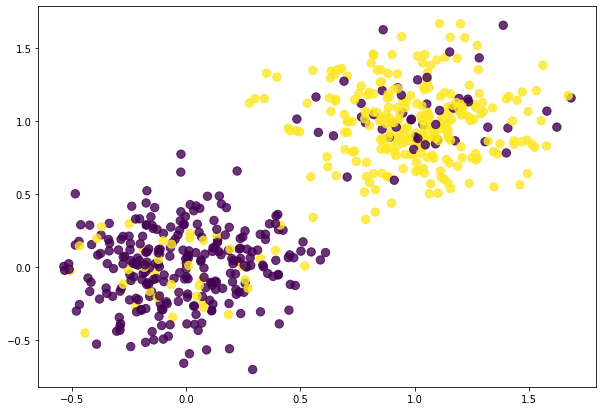

In [152]:
# The data is generated using the functions provided in the course. The first assignment in particular. 
fig = plt.figure(figsize=(10,7)) 
Y2_n0 = flipLabels(Y,15)
plt.scatter(X[:,0], X[:,1], s=70, c=Y2_n0, alpha=0.8)

In [150]:
class WeakClassifier():
    def __init__(self):
        self.plrty = 1
        self.column_idx = None
        self.thres= None
        self.alpha = None

    def predict(self, X):
        n = X.shape[0]
        X_column = X[:, self.column_idx]
        predicted_labels = np.ones(n) 
        if self.plrty == 1:  # From the literature the classification is always between -1 and 1 
            predicted_labels[X_column < self.thres] = -1
        else:
            predicted_labels[X_column > self.thres] = -1

        return predicted_labels


class AdaptiveBoost():

    def __init__(self, n_classifier):
        self.n_classifier = n_classifier

    def xtrain(self, X, target):
        n, Dim = X.shape

        # First let us initialize the weights with one common value. By convention its 1/number of 
        # observations
        weights= np.full(n, (1 / n))
        
        # Because we are going to be iterating over different classifiers so we need to store them somewhere
        self.classifiers = []
        
        #Now we can loop over the classifiers to compute there different results and then merge them together.
        for _ in range(self.n_classifier):
            classifier = WeakClassifier()

            minimum_err= float('inf')
            
            #Lets find the best thresfrom X and dimension
            for dimension in range(Dim):
                X_column = X[:, dimension]  # Get a particular column
                thresholds = np.unique(X_column) #From every column lets get unique values to give them 
                #required polarity based on value

                #Loop through the thresholds to assign polarity
                for thres in thresholds:
                    # Set the polarity to 1. The threshold is going to be based on this value. 
                    p = 1
                    predicted_labels = np.ones(n)
                    predicted_labels[X_column < thres] = -1 #Storage for the predicted labels

                    #Sum up the errors for the labels classified wrongly.
                    wrong_classifications = weights[target != predicted_labels]
                    err= sum(wrong_classifications)

                    if err> 0.5:
                        err= 1 - err
                        p = -1

                    #Lets store the best configuration information 
                    if err< minimum_err:
                        classifier.plrty = p
                        classifier.thres= thres
                        classifier.column_idx = dimension
                        minimum_err= err

            # The last step is calculating alpha, first we need to get the Episilon
            Episilon = 3e-20
            
            # Calculate alpha
            classifier.alpha = 0.5 * np.log((1.0 - minimum_err+ Episilon) / (minimum_err+ Episilon))

        
            # Update the weights
            weights*= np.exp(-classifier.alpha * target * predicted_labels) 
        
            weights/= np.sum(weights)
            
            # Add the classifier to the list created.
            self.classifiers.append(classifier)
            
        #After the training phase then predict. 
    def predict(self, X):
        classifier_preds = [classifier.alpha * classifier.predict(X) for classifier in self.classifiers]
        Predicted_y = np.sum(classifier_preds, axis=0)
        Predicted_y = np.sign(Predicted_y)

        return Predicted_y

def accuracy(y_true, Predicted_y):
    accuracy = np.sum(y_true == Predicted_y) / len(y_true)
    return accuracy

In [137]:
ada = AdaptiveBoost(9)
ada.xtrain(X,Y)
Pred = ada.predict(Xte)
accuracy(Y,Pred)

0.9366666666666666

Text(0.5, 1.0, 'Predicted Y')

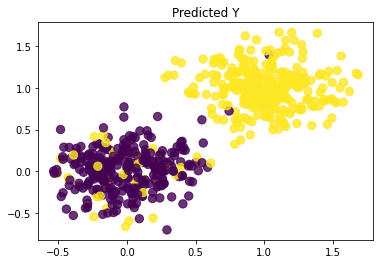

In [142]:
plt.scatter(X[:,0], X[:,1], s=70, c=Pred, alpha=0.8)
plt.title("Predicted Y")

Text(0.5, 1.0, 'True Y')

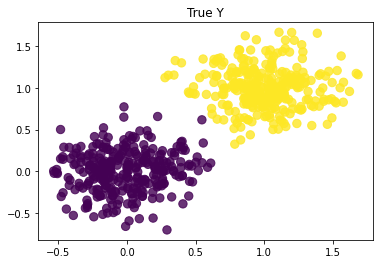

In [143]:
plt.scatter(X[:,0], X[:,1], s=70, c=Y, alpha=0.8)
plt.title('True Y')

In [165]:
## Add some noise
ada2 = AdaptiveBoost(10)
ada2.xtrain(X,Y2_n0)
Pred2 = ada.predict(Xte)
accuracy(Y2_n0,Pred)

0.7966666666666666

Text(0.5, 1.0, 'Predicted Y with Noise Y2_n0')

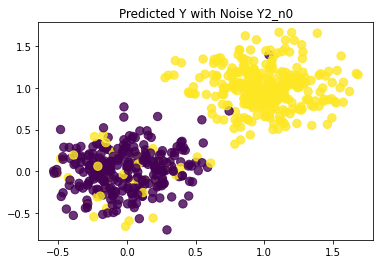

In [166]:
plt.scatter(X[:,0], X[:,1], s=70, c=Pred2, alpha=0.8)
plt.title('Predicted Y with Noise Y2_n0')

Text(0.5, 1.0, 'True Y2_n0 with Noise')

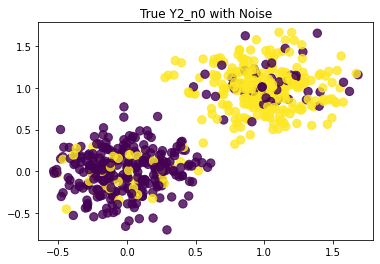

In [167]:
plt.scatter(X[:,0], X[:,1], s=70, c=Y2_n0, alpha=0.8)
plt.title('True Y2_n0 with Noise')